In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [ ]:

def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data2/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [ ]:
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data2/train/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data2/train/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]
    return np.array(keypoints, dtype=np.float16)

In [ ]:
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data2/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data2/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/aug_data2/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
# train = train.shuffle(500)
train = train.batch(16)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
# test = test.shuffle(300)
test = test.batch(16)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
# val = val.shuffle(200)
val = val.batch(16)
val = val.prefetch(4)

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

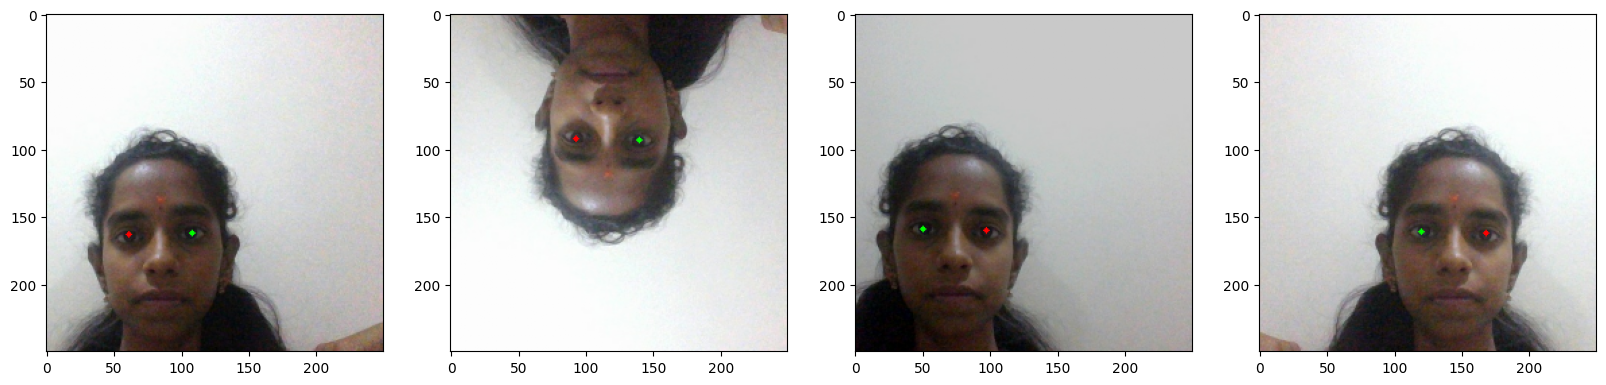

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx].copy()
    sample_coords = res[1][0][idx]

    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)

    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout,Flatten
from tensorflow.keras.applications import ResNet152V2

In [ ]:
# model = Sequential([
#     Input(shape=(250,250,3)),
#     ResNet152V2(include_top=False, input_shape=(250,250,3)),
#     Conv2D(512, 3, padding='same', activation='relu'),
#     Conv2D(512, 3, padding='same', activation='relu'),
#     Conv2D(256, 3, 2, padding='same', activation='relu'),
#     Conv2D(256, 2, 2, activation='relu'),
#     Dropout(0.05),


#     Conv2D(4, 2, 2),
#     Reshape((4,)),
# ])

from tensorflow.keras.layers import Input, Conv2D, Dropout, Reshape, BatchNormalization, MaxPooling2D
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential

model = Sequential([
    Input(shape=(250, 250, 3)),
    ResNet152V2(include_top=False, input_shape=(250, 250, 3)),
    Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Conv2D(256, 3, 2, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Conv2D(256, 2, 2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(4, 2, 2),
    Reshape((4,))
])



In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
test_data = test.as_numpy_iterator()


In [ ]:
test_sample = test_data.next()
yhat = model.predict(test_sample[0])

1/1 [==============================] - 0s 341ms/step


In [ ]:
import keras
model.compile(optimizer, loss,,run_eagerly=True)

In [ ]:
# prompt: generate compile function along with keras accuracy metrics



In [ ]:
y_true = []
for label in test_labels:
    keypoints = label[0].numpy()  # Assuming the keypoints are stored in the first element of the tuple
    y_true.append(keypoints)

# Convert the list of numpy arrays to a single numpy array
y_true = np.array(y_true)

In [ ]:
def custom_accuracy(y_true, yhat):
    # Define a threshold for correctness
    threshold = 0.5

    # Convert predictions to binary values based on the threshold
    y_pred_binary = tf.argmax(yhat, axis=1)
    y_pred_binary = tf.cast(y_pred_binary, tf.int32)

    # Reshape y_true to have the same shape as y_pred_binary
    y_true = tf.reshape(y_true, [-1, 4])

    # Convert true values to binary (assuming they are continuous)
    y_true_binary = tf.cast(y_true >= threshold, tf.int32)

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_true_binary, y_pred_binary), tf.float32))

    return accuracy

In [ ]:

model.compile(optimizer, loss,metrics=['mae'])


In [ ]:
hist = model.fit(train,validation_data=val,epochs=10)

Epoch 1/10
30/30 [==============================] - 1405s 44s/step - loss: 3.2029 - mae: 0.6487 - val_loss: 145649693991370752.0000 - val_mae: 288673184.0000
Epoch 2/10
30/30 [==============================] - 1352s 45s/step - loss: 2.6746 - mae: 0.3897 - val_loss: 52848885382512640.0000 - val_mae: 175087600.0000
Epoch 3/10
20/30 [===================>..........] - ETA: 6:41 - loss: 2.6540 - mae: 0.3869

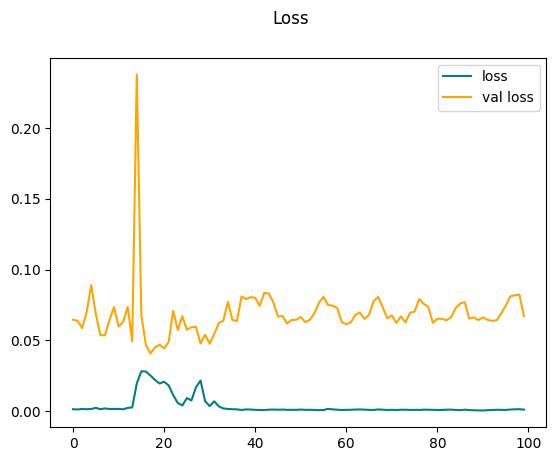

In [ ]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

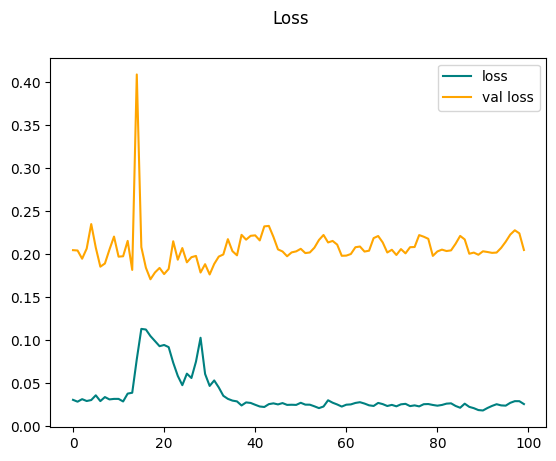

In [ ]:
plt.plot(hist.history['mae'], color='teal', label='loss')
plt.plot(hist.history['val_mae'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

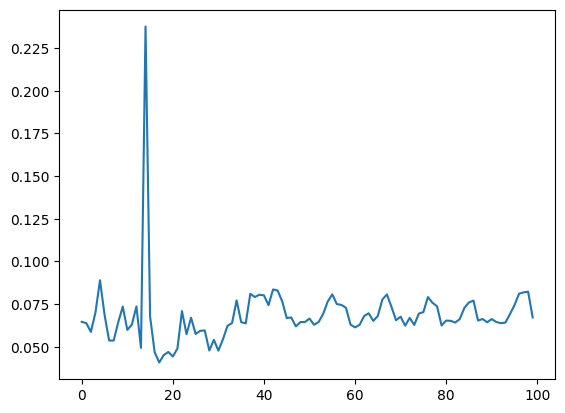

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['val_loss'])

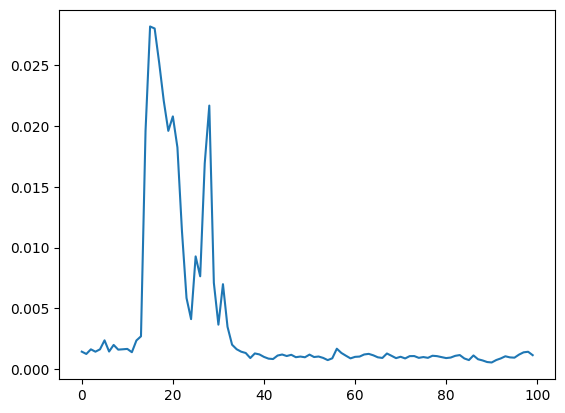

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])

In [ ]:
training_mae = hist.history['mae']

In [ ]:
np.mean(training_mae)

0.036160747054964304

In [ ]:
val_mae=hist.history['val_mae']

In [ ]:
np.mean(val_mae)

0.20727329954504967

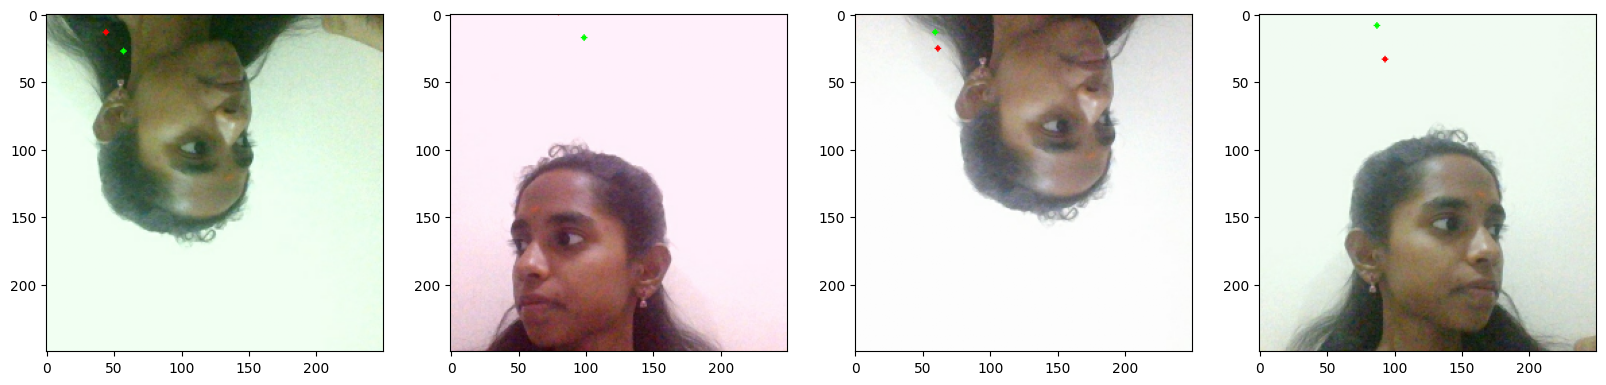

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[idx]

    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)

    ax[idx].imshow(sample_image)